# Training NN for the final Decision Making

## Load Tensorflow and check GPU availability

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2024-06-13 19:08:51.345136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 19:08:51.345164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 19:08:51.345939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 19:08:51.350438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 19:08:51.938694: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2024-06-13 19:08:52.747775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-06-13 19:08:52.752779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 6271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

df = pd.read_parquet('data/preliminary_results_x.parquet')

# IMPORTANT: set labels:
df.loc[df['label'].str.startswith(('phishing', 'malware', 'misp', 'dga')), 'label'] = 'malign'
df.loc[df['label'] != 'malign', 'label'] = 'benign'

class_map = {"benign": 0, "malign": 1}

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")


pd.set_option('display.max_columns', None)
features

Total samples: 100000


,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,malware_cnn_result,malware_lgbm_result,malware_xgboost_result,dga_binary_nn_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,total_sum,total_avg,total_prod
54451,0.6,0.225,1.000000,0.833333,1.0,0.750,1.000000,0.833333,1.0,0.777778,1.0,0.008122,0.002815,1.366864e-03,0.066331,0.013630,1.0,0.000191,0.002436,6.067854e-23,1.092264,0.182044,2.825370e-11,1.002627,0.334209,4.655318e-07,2.094891,0.209489,7.981044e-40
247717,1.0,0.750,0.833333,0.291667,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000682,0.000621,3.579364e-04,0.007201,0.002786,0.0,0.000052,0.002233,3.490693e-03,0.011647,0.001941,0.000000e+00,0.002285,0.000762,0.000000e+00,0.017423,0.001742,0.000000e+00
15621,0.6,0.225,1.000000,0.833333,1.0,0.375,1.000000,0.708333,1.0,0.722222,1.0,0.794902,0.967936,9.999437e-01,0.689681,0.941273,0.0,0.000533,0.002408,7.239705e-07,5.393736,0.898956,4.994589e-01,0.002941,0.000980,0.000000e+00,5.396678,0.539668,0.000000e+00
255533,0.9,0.525,0.833333,0.291667,1.0,0.875,0.833333,0.250000,1.0,0.722222,0.0,0.000314,0.000381,3.409265e-07,0.055679,0.000929,0.0,0.000280,0.002364,1.192370e-35,0.057303,0.009551,0.000000e+00,0.002644,0.000881,0.000000e+00,0.059947,0.005995,0.000000e+00
89645,0.9,0.550,0.833333,0.291667,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000668,0.000933,6.330108e-04,0.071273,0.033787,0.0,0.000061,0.002233,5.018924e-04,0.107293,0.017882,0.000000e+00,0.002294,0.000765,0.000000e+00,0.110089,0.011009,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343814,1.0,0.700,0.833333,0.291667,1.0,1.000,0.833333,0.416667,1.0,1.000000,1.0,0.000353,0.000631,1.249553e-04,0.003323,0.000713,1.0,0.000052,0.002233,3.854592e-02,1.005146,0.167524,6.602678e-17,1.002286,0.334095,1.171542e-07,2.045977,0.204598,2.981647e-25
104123,0.6,0.200,1.000000,0.833333,1.0,0.500,0.833333,0.041667,1.0,0.666667,0.0,0.000520,0.000777,2.489036e-04,0.144647,0.010928,1.0,0.000305,0.002364,8.776547e-26,0.157121,0.026187,0.000000e+00,1.002669,0.334223,7.199457e-07,1.159789,0.115979,0.000000e+00
380872,1.0,0.725,0.833333,0.291667,1.0,0.625,1.000000,0.708333,1.0,0.722222,0.0,0.006750,0.010146,1.054552e-02,0.051278,0.027170,0.0,0.677820,0.568785,2.559731e-02,0.105889,0.017648,0.000000e+00,1.246605,0.415535,0.000000e+00,1.378092,0.137809,0.000000e+00
275135,1.0,0.700,0.833333,0.291667,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000425,0.000540,2.749782e-03,0.008847,0.002785,0.0,0.000050,0.002233,7.275866e-01,0.015347,0.002558,0.000000e+00,0.002283,0.000761,0.000000e+00,0.745217,0.074522,0.000000e+00


# Data preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,malware_cnn_result,malware_lgbm_result,malware_xgboost_result,dga_binary_nn_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,total_sum,total_avg,total_prod
0,0.6,0.257143,1.000000,0.952381,1.0,0.750,1.000000,0.833333,1.0,0.777778,1.0,0.007990,0.002456,1.366864e-03,0.066430,0.013656,1.0,0.000149,0.000209,6.067854e-23,0.182268,0.182268,2.856502e-11,0.346461,0.346461,5.223303e-07,0.229910,0.229910,2.206768e-39
1,1.0,0.857143,0.833333,0.333333,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000549,0.000258,3.579364e-04,0.007211,0.002792,0.0,0.000009,0.000000,3.490693e-03,0.001812,0.001812,0.000000e+00,0.000003,0.000003,0.000000e+00,0.001477,0.001477,0.000000e+00
2,0.6,0.257143,1.000000,0.952381,1.0,0.375,1.000000,0.708333,1.0,0.722222,1.0,0.794877,0.969108,9.999437e-01,0.690715,0.943112,0.0,0.000494,0.000181,7.239705e-07,0.900585,0.900585,5.049623e-01,0.000230,0.000230,0.000000e+00,0.592965,0.592965,0.000000e+00
3,0.9,0.600000,0.833333,0.333333,1.0,0.875,0.826087,0.250000,1.0,0.722222,0.0,0.000181,0.000018,3.409265e-07,0.055762,0.000931,0.0,0.000238,0.000135,1.192370e-35,0.009436,0.009436,0.000000e+00,0.000127,0.000127,0.000000e+00,0.006152,0.006152,0.000000e+00
4,0.9,0.628571,0.833333,0.333333,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000535,0.000571,6.330108e-04,0.071380,0.033853,0.0,0.000017,0.000000,5.018924e-04,0.017784,0.017784,0.000000e+00,0.000006,0.000006,0.000000e+00,0.011666,0.011666,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.800000,0.833333,0.333333,1.0,1.000,0.826087,0.416667,1.0,1.000000,1.0,0.000221,0.000268,1.249553e-04,0.003328,0.000715,1.0,0.000009,0.000000,3.854592e-02,0.167720,0.167720,6.675432e-17,0.346342,0.346342,1.314479e-07,0.224531,0.224531,8.244289e-25
99996,0.6,0.228571,1.000000,0.952381,1.0,0.500,0.826087,0.041667,1.0,0.666667,0.0,0.000387,0.000415,2.489036e-04,0.144864,0.010949,1.0,0.000264,0.000135,8.776547e-26,0.026105,0.026105,0.000000e+00,0.346475,0.346475,8.077846e-07,0.127088,0.127088,0.000000e+00
99997,1.0,0.828571,0.833333,0.333333,1.0,0.625,1.000000,0.708333,1.0,0.722222,0.0,0.006618,0.009798,1.054552e-02,0.051355,0.027223,0.0,0.684465,0.585975,2.559731e-02,0.017550,0.017550,0.000000e+00,0.430960,0.430960,0.000000e+00,0.151092,0.151092,0.000000e+00
99998,1.0,0.800000,0.833333,0.333333,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.000293,0.000177,2.749782e-03,0.008861,0.002791,0.0,0.000007,0.000000,7.275866e-01,0.002430,0.002430,0.000000e+00,0.000002,0.000002,0.000000e+00,0.081503,0.081503,0.000000e+00


# Train-test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

no_features = 33

model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(no_features,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=[Precision(), Recall(), AUC()]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                960       
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

2024-06-13 19:08:56.274396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-06-13 19:08:56.276085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


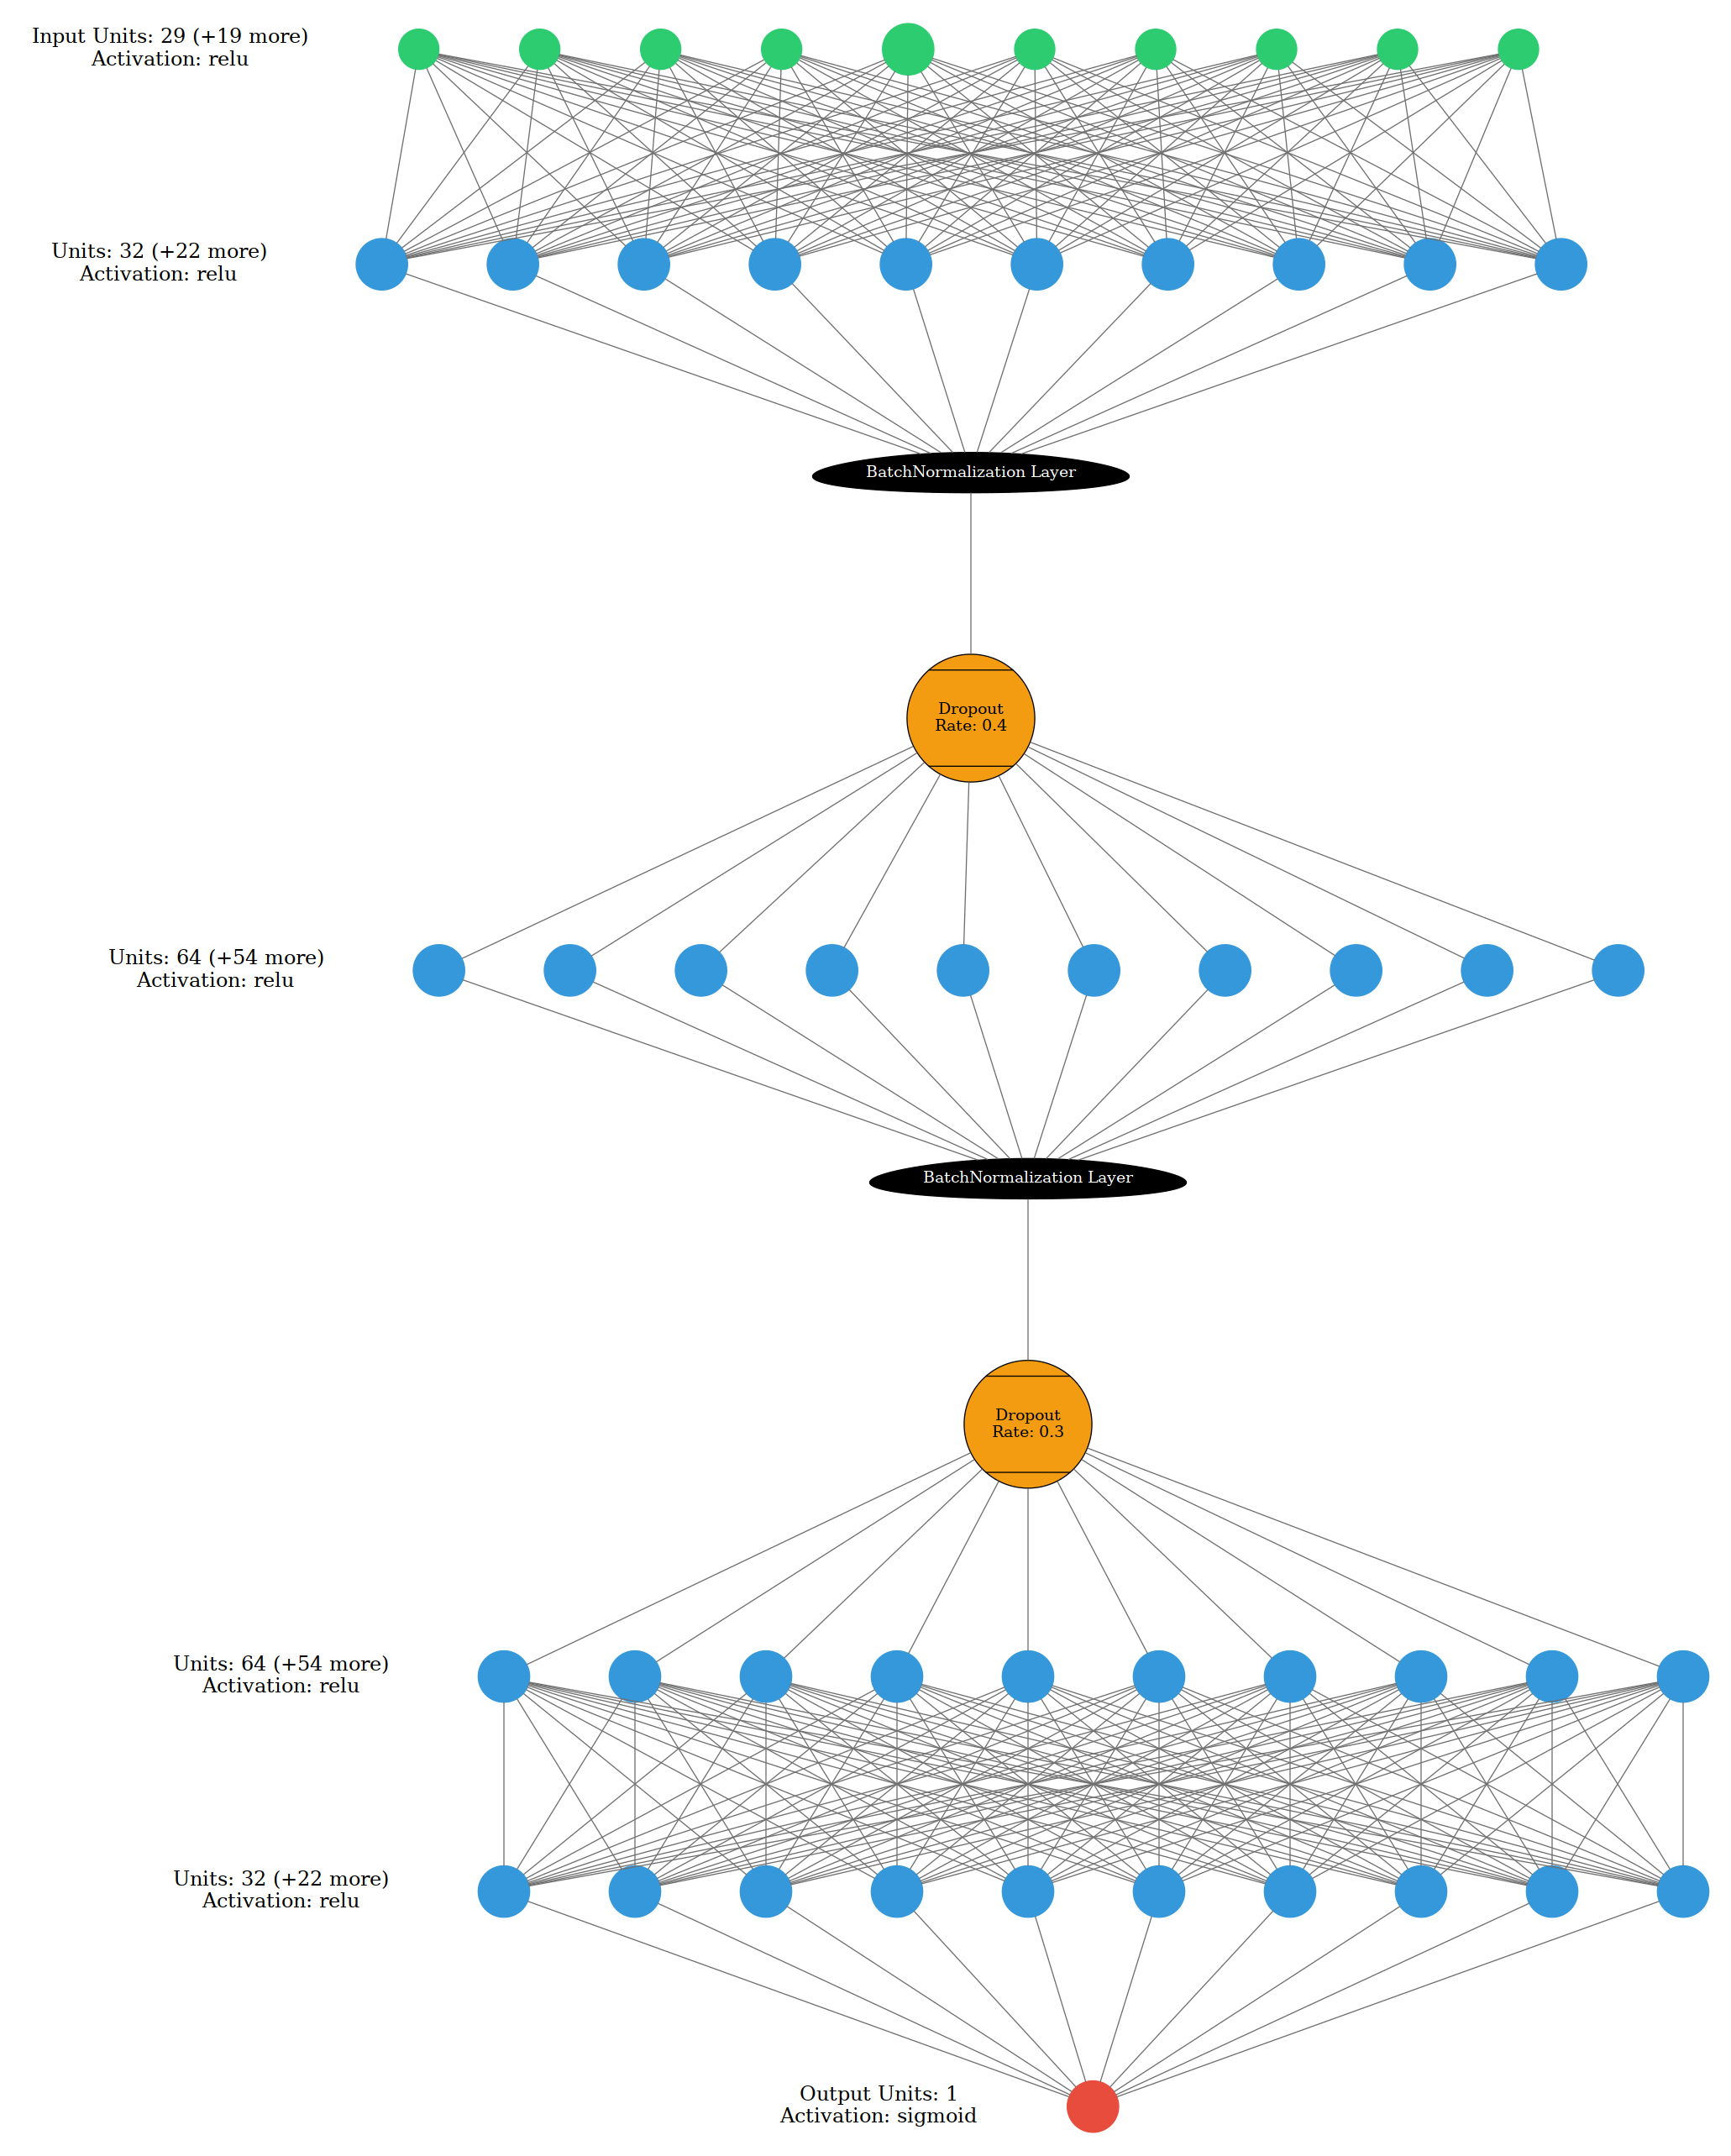

In [6]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [7]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# Calculate class weights
class_weights = {0: 1.0, 1: 0.1} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=35,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/35


2024-06-13 19:09:06.770482: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-13 19:09:08.550711: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f412457d490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-13 19:09:08.550730: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-06-13 19:09:08.555216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 19:09:08.567812: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718298548.635827  765778 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 4s 5ms/step - loss: 2.5500 - precision: 0.3545 - recall: 0.9602 - auc: 0.7857 - val_loss: 2.4945 - val_precision: 0.3363 - val_recall: 0.9969 - val_auc: 0.8105
Epoch 2/35
157/157 [==============================] - 1s 4ms/step - loss: 2.4176 - precision: 0.3834 - recall: 0.9295 - auc: 0.7992 - val_loss: 2.4166 - val_precision: 0.4313 - val_recall: 0.9328 - val_auc: 0.8694
Epoch 3/35
157/157 [==============================] - 1s 4ms/step - loss: 2.3075 - precision: 0.4303 - recall: 0.8727 - auc: 0.8075 - val_loss: 2.3186 - val_precision: 0.5914 - val_recall: 0.8271 - val_auc: 0.8901
Epoch 4/35
157/157 [==============================] - 1s 4ms/step - loss: 2.2145 - precision: 0.5031 - recall: 0.8176 - auc: 0.8182 - val_loss: 2.2497 - val_precision: 0.7786 - val_recall: 0.7653 - val_auc: 0.9033
Epoch 5/35
157/157 [==============================] - 1s 4ms/step - loss: 2.1340 - precision: 0.5960 - recall: 0.7572 - auc: 0.8257 - val_loss: 2.1957 - va

# Save the model

In [8]:
model.save('models/decision_nn_model.keras')

# Display training results

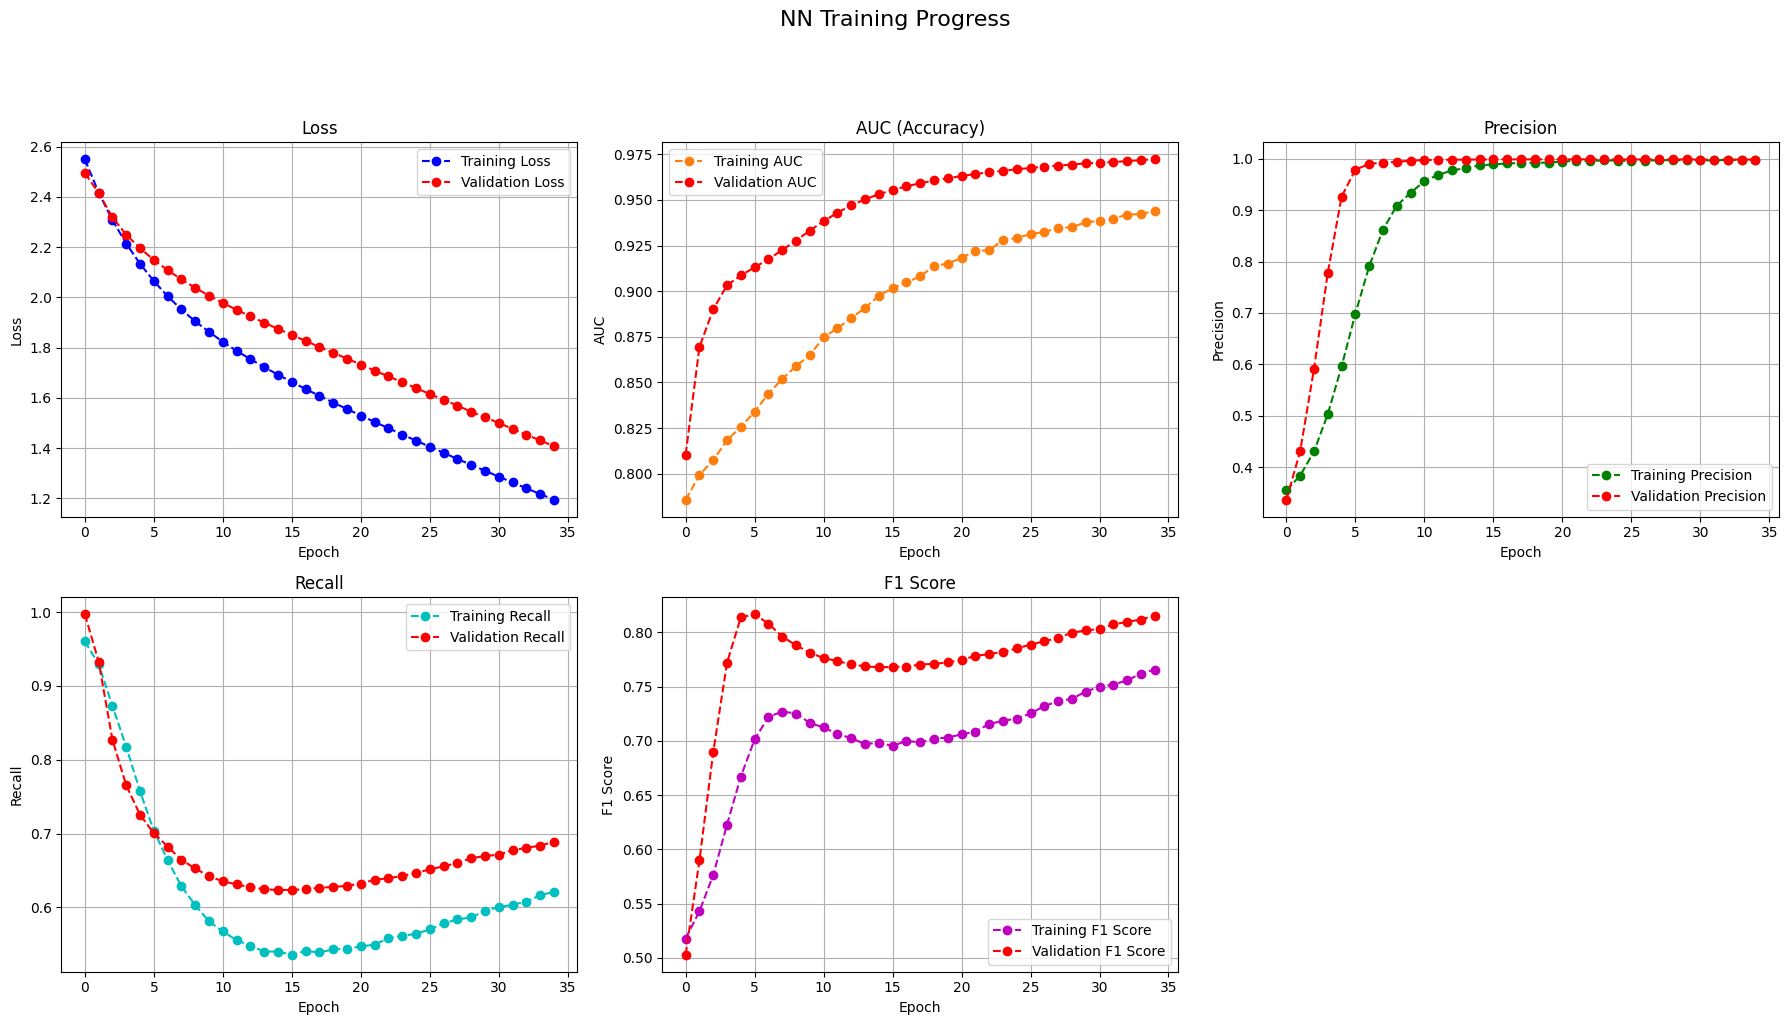

In [9]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score
epoch_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

625/625 [==============================] - 1s 1ms/step - loss: 1.4073 - precision: 0.9987 - recall: 0.6887 - auc: 0.9723
Loss =  1.4073247909545898
Accuracy =  0.9986984729766846
625/625 [==============================] - 1s 945us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.8648    0.9995    0.9273     13315
   Malicious     0.9987    0.6887    0.8152      6685

    accuracy                         0.8956     20000
   macro avg     0.9317    0.8441    0.8713     20000
weighted avg     0.9095    0.8956    0.8898     20000

False Positive Rate = 0.00045061960195268494

Confusion Matrix:
[[13309     6]
 [ 2081  4604]]


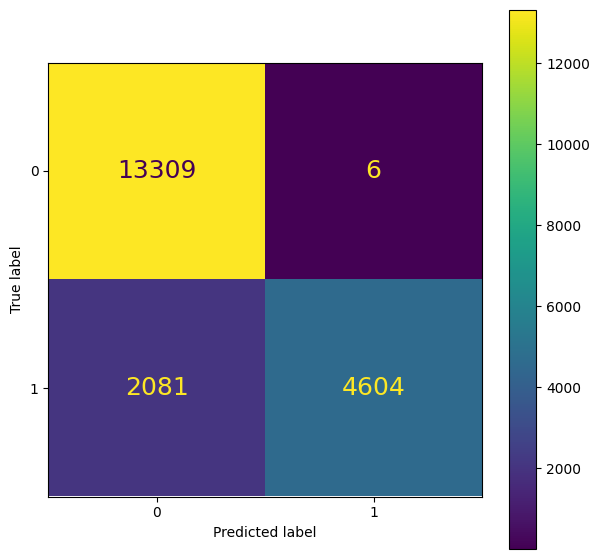

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

# Feature Importance Analysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 1001it [00:55, 15.16it/s]                                                                                                                                              
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


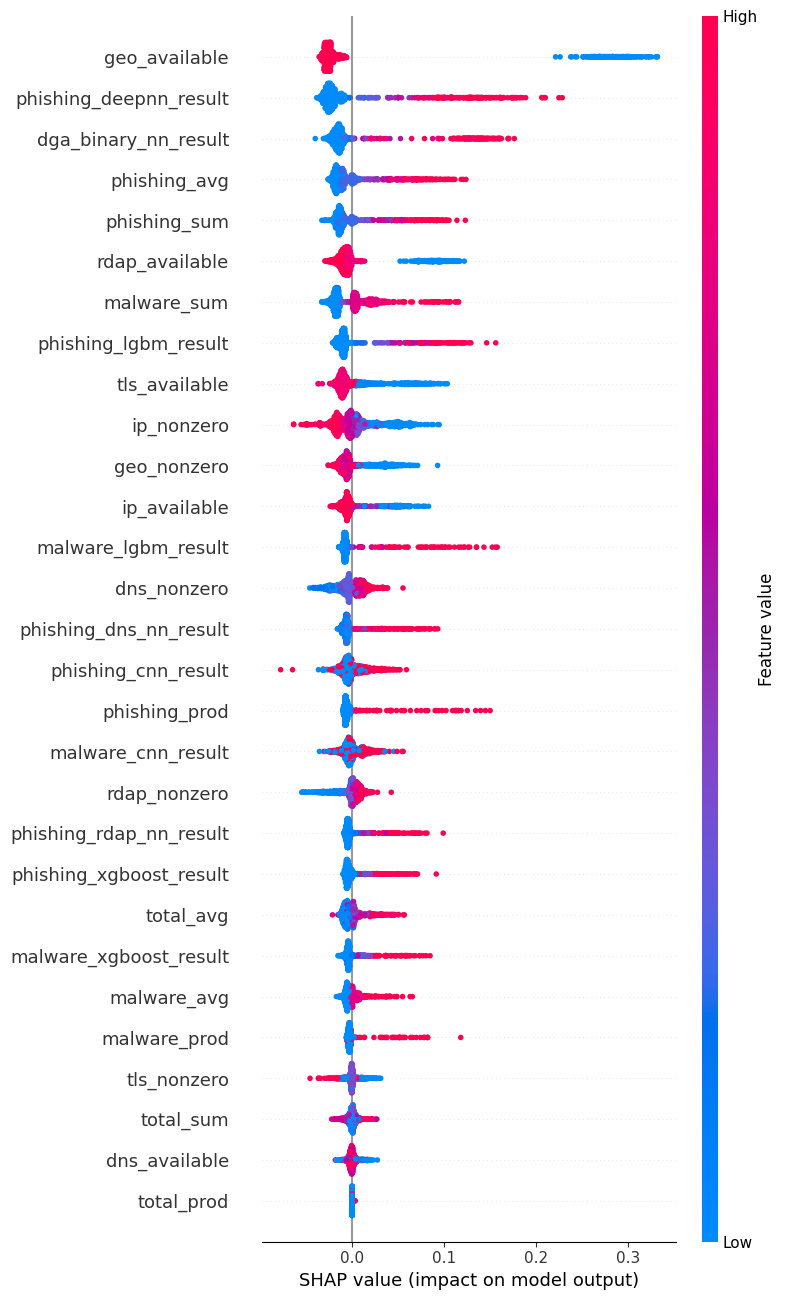

In [11]:
import shap

# Ensure that X_train and X_test are DataFrames with the correct column names
# You can set the column names from the 'features' DataFrame like this:
X_train.columns = features.columns
X_test.columns = features.columns

n_samples = 1000

# Convert your training set to a NumPy format if it's not already
background = X_train[:n_samples].to_numpy()

# Use the generic SHAP Explainer interface
explainer = shap.Explainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer(X_test[:n_samples].to_numpy())

# Plotting the summary plot for feature importance
# Use the column names from the 'features' DataFrame as the feature names
shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)


# Make test predictions

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model('dga_binary_model.keras')
scaler = joblib.load("dga_binary_scaler.joblib")

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/lex-benign_2312_anonymized.parquet',
    '../feature-extraction/floor/lex-umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "dga"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! DGA !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")


